# Retrieving Pseudo-MPC Observations for EROS in txt file (from mpc txt file version)

## Objectives
In this example show how to retrieve pseudo-MPC data from Bill Gray's website. We will use the Tudat Horizons interface to compare observation ouput and load the standard SPICE kernels.

## Key API References

## Import statements

In [27]:
from tudatpy.data.mpc import BatchMPC
from tudatpy.kernel.numerical_simulation import environment_setup
from tudatpy.kernel.numerical_simulation.estimation_setup import observation
from tudatpy.kernel.interface import spice
from tudatpy.kernel import numerical_simulation
from tudatpy.data.horizons import HorizonsQuery


from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

from tudatpy.kernel.numerical_simulation import environment_setup
from tudatpy.kernel.numerical_simulation import propagation_setup
from tudatpy.kernel.numerical_simulation import estimation, estimation_setup
from tudatpy.kernel.numerical_simulation.estimation_setup import observation


# Load spice kernels
spice.load_standard_kernels()

## Workflow
Unlike what already done in the example [Retrieving_mpc_observation_data (ADD LINK)](), we cannout initialize the BatchMPC object yet, since astroquery...is not linked to Bill Gray's html page. We therefore need to 

1) parse B.G.'s html page containing the data, and retrieve the information needed (obs. time, angular observables, station codes, obs. band, etc...).
2) feed this information into a table that is similar to the one created (in the other example) using the `.get_observations()` method.
3) convert the newly created table into a `Batch.MPC` object using `.from_astropy()` .

### 1) Parsing the html page

In [51]:
#FOR EROS
from astroquery.mpc import MPC
import requests
import re
from tudatpy import constants

from astropy.time import Time
from astropy.table import Table, Column
from bs4 import BeautifulSoup
import pandas as pd

MPC.query_object = requests.get("https://www.minorplanetcenter.net/tmp2/Eros.txt", "433") #this link might need to be updated often

# Initialize lists to hold the extracted data
numbers = []
epochs = []
RAs = []
DECs = []
bands = []
observatories = []

for i, line in enumerate(MPC.query_object.text.splitlines()):
    if line[14] == 's':
        continue
    number = i+1
    #print(f'observation n. {number}')
    
    # Extract the observation string (without the band and observatory)
    observation_string = line[15:]
    #print(observation_string)
    
    year = observation_string[0:4]  # Year (e.g., 2023)
    if float(year) >= 2018 and float(year) <= 2023:
        month = observation_string[5:7]  # Month (e.g., 04)
        if float(year) == 2023:
            if int(month) >=7:
                continue
        #print(month)
        date_part, frac_day = observation_string[8:17].split('.')
        #print(date_part,frac_day)
        #print(f'Day:{date_part}, Fraction of Day:{frac_day}')
        numbers.append(number)
    
        # Calculate the time in hours, minutes, seconds
        hours = float("0." + frac_day) * 24
        minutes = (hours % 1) * 60
        seconds = (minutes % 1) * 60
        seconds_int = int(seconds)
        microseconds = int((seconds - seconds_int) * 1_000_000)
        
        if round(seconds) == 60: 
            minutes = minutes + 1
            seconds = 0
        #print(f'Hours:{hours}, Minutes:{minutes}, Seconds:{seconds}')
        # Convert to Julian date
        time_string = f"{date_part} {int(hours):02}:{int(minutes):02}:{seconds:02}"
        epoch = f'{year}-{month}-{date_part} {int(hours):02}:{int(minutes):02}:{seconds_int:02}.{microseconds:06}'
        #print(f'Epoch:{epoch}')
        dt = datetime.strptime(epoch, "%Y-%m-%d %H:%M:%S.%f")
        dt_jd = Time(dt).jd
        epochs.append(dt_jd)
    
        ra_dec_str = observation_string[17:43]  # RA and DEC part
        #print(f'ra & dec str:{ra_dec_str}')
        ra_part = ra_dec_str[:12].strip()  # Right Ascension
        #print(f'ra part: {ra_part}')
        dec_part = ra_dec_str[12:].strip()  # Declination (considering no space if negative)
        #print(f'dec part:{dec_part}')
    
        #Right Ascension
        parts_RA = ra_part.split()
        hours_RA = float(parts_RA[0])
        minutes_RA = float(parts_RA[1]) if len(parts_RA) > 1 else 0
        seconds_RA = float(parts_RA[2]) if len(parts_RA) > 2 else 0
        deg_ra = 15*hours_RA + 0.25*minutes_RA + seconds_RA/240
    
        #Declination
        parts_DEC = dec_part.split()
        degrees_DEC = float(parts_DEC[0])
        minutes_DEC = float(parts_DEC[1]) if len(parts_DEC) > 1 else 0
        seconds_DEC = float(parts_DEC[2]) if len(parts_DEC) > 2 else 0
        if parts_DEC[0][0] == '-':
            deg_dec = - (abs(degrees_DEC) + minutes_DEC / 60 + seconds_DEC / 3600)
        else:
            deg_dec = (abs(degrees_DEC) + minutes_DEC/ 60 + seconds_DEC/ 3600)
        #print(f'deg_ra {deg_ra}')
        #print(f'deg_dec {deg_dec}')
        # Extract Band
        band = observation_string[-10:-8]
    
        bands.append(band)

        # Extract the observatory code
        observatory = line[-3:]
        #print(observatory)
        observatories.append(observatory)
        RAs.append(deg_ra) #this is in degrees
        DECs.append(deg_dec) #this is in degrees

### 2) Feeding the table
Note that RA and Dec are given in **degrees** (they could be given in radians, but we leave it this way to be consistent with the previous Eros example)

In [30]:
# Create the table
table = Table()

# Add columns to the table
table.add_column(Column(name='number', data= np.transpose(['433']*len(numbers))))
table.add_column(Column(name='designation', data= np.transpose(['EROS']*len(numbers))))
table.add_column(Column(name='discovery', data= np.transpose(['NaN']*len(numbers))))
table.add_column(Column(name='note1', data= np.transpose(['NaN']*len(numbers))))
table.add_column(Column(name='note2', data= np.transpose(['NaN']*len(numbers))))
table.add_column(Column(name='epoch', data=epochs))
table.add_column(Column(name='RA', data=RAs, unit='deg'))  # RA in degrees
table.add_column(Column(name='DEC', data=DECs, unit='deg'))  # DEC in degrees
table.add_column(Column(name='mag', data=np.transpose(['NaN']*len(numbers))))
table.add_column(Column(name='band', data=bands))
table.add_column(Column(name='observatory', data=observatories))

# Display the table
print(table)

number designation discovery note1 ...         DEC         mag band observatory
                                   ...         deg                             
------ ----------- --------- ----- ... ------------------- --- ---- -----------
   433        EROS       NaN   NaN ... -3.0439166666666666 NaN   Ro         K95
   433        EROS       NaN   NaN ...  -3.039972222222222 NaN   Ro         K95
   433        EROS       NaN   NaN ... -3.0386944444444444 NaN   Ro         K95
   433        EROS       NaN   NaN ...   4.705555555555556 NaN   oU         T05
   433        EROS       NaN   NaN ...   4.707972222222223 NaN   oU         T05
   433        EROS       NaN   NaN ...   4.711333333333333 NaN   oU         T05
   433        EROS       NaN   NaN ...   9.080472222222221 NaN   GU         G96
   433        EROS       NaN   NaN ...   9.083777777777778 NaN   GU         G96
   433        EROS       NaN   NaN ...   9.085472222222222 NaN   GU         G96
   ...         ...       ...   ... ...  

### Creating the BatchMPC object
Note that batch1.table.query always gives the result in **radians**.  

In [38]:
batch1 = BatchMPC()
batch1.from_astropy(table, in_degrees = True)
batch1.summary()

batch1.filter(
    epoch_start=datetime(2018, 1, 1),
    observatories_exclude=["C51", "C57", "C59"],
    epoch_end = datetime(2023, 7, 1)
)

print(batch1.table)
print(batch1.observatories_table(only_in_batch=True, only_space_telescopes=False, include_positions=False))
print('\n')
# We can also directly have a look at the the observations themselves, for example, lets take a look at the first and final observations from TESS and WISE. The table property allows for read only access to the observations in pandas dataframe format.

#obs_by_Pan_STARRS = batch1.table.query("observatory == 'C59'").loc[:, ["number", "epochUTC", "RA", "DEC"]].iloc[[0, -1]]
#obs_by_Calar_Alto = batch1.table.query("observatory == 'G02'").loc[:, ["number", "epochUTC", "RA", "DEC"]].iloc[[0, -1]]

#print("Initial and Final Observations by Pan_STARRS")
#print(obs_by_Pan_STARRS) #RA and Dec are given in radians!
#print('\n')
#print("Initial and Final Observations by Calar Alto-Schmidt")
#print(obs_by_Calar_Alto) #RA and Dec are given in radians!


   Batch Summary:
1. Batch includes 1 minor planets:
   ['433']
2. Batch includes 3111 observations, including 1735 observations from space telescopes
3. The observations range from 2018-05-01 03:22:18.336012 to 2023-06-27 00:37:43.680017
   In seconds TDB since J2000: 578417007.5214744 to 741098332.8642726
   In Julian Days: 2458239.64049 to 2460122.5262
4. The batch contains observations from 54 observatories, including 4 space telescopes

     number designation discovery note1 note2         epoch        RA  \
0       433        EROS       NaN   NaN   NaN  2.458240e+06  6.056488   
1       433        EROS       NaN   NaN   NaN  2.458240e+06  6.056609   
2       433        EROS       NaN   NaN   NaN  2.458240e+06  6.056649   
3       433        EROS       NaN   NaN   NaN  2.458267e+06  0.001341   
4       433        EROS       NaN   NaN   NaN  2.458267e+06  0.001408   
...     ...         ...       ...   ...   ...           ...       ...   
3106    433        EROS       NaN   NaN   

### Retrieve Observation Collection

In [39]:
# List the bodies for our environment
"""
A system of bodies must be created to keep observatories' positions consistent with Earth's shape model and to allow the attachment of these observatories to Earth. For the purposes of this example, we keep it as simple as possible. See the [Estimation with MPC](https://docs.tudat.space/en/latest/_src_getting_started/_src_examples/notebooks/estimation/estimation_with_mpc.html) for a more complete setup and explanation appropriate for estimation. For our bodies, we only use Earth and the Sun. We set our origin to `"SSB"`, the solar system barycenter. We use the default body settings from the `SPICE` kernel to initialise the planet and use it to create a system of bodies. This system of bodies is used in the `to_tudat()` method.
"""

bodies_to_create = [
    "Sun", 
    "Earth", 
    "Moon", 
    "Jupiter", 
    "Saturn", 
    "Mars", 
    "Mercury", 
    "Neptune", 
    "Uranus", 
    "Venus"
]

# Create default body settings
global_frame_origin = "SSB"
global_frame_orientation = "J2000"

body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation)


# Create system of bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

# Retrieve JUICE' body name from BatchMPC and set its centre to enable its propapgation
bodies_to_propagate = batch1.MPC_objects
central_bodies = [global_frame_origin]

# Now that our batch is ready, we can transform it to a Tudat `ObservationCollection` object using the `to_tudat()` method.
#
# The `.to_tudat()` does the following for us:
#
# 1. Creates an empty body for each minor planet with their MPC code as a name.
# 2. Adds this body to the system of bodies inputted to the method.
# 3. Retrieves the global position of the terrestrial observatories in the batch and adds these stations to the Tudat environment.
# 4. Creates link definitions between each unique terrestrial observatory/ minor planet combination in the batch.
# 5. (Optionally) creates a link definition between each space telescope / minor planet combination in the batch. This requires an addional input.
# 6. Creates a `SingleObservationSet` object for each unique link that includes all observations for that link.
# 7. Returns an `ObservationCollection` object.
# 7. Returns an `ObservationCollection` object.
#
# If our batch includes space telescopes like WISE and TESS we must either link their Tudat name or exclude them. For now we exclude them by setting `included_satellites` to `None`. The additional features section shows an example of how to link satellites to the `to_tudat()` method. The '.to_tudat()' method does not alter the batch object itself.

observation_collection = batch1.to_tudat(bodies, included_satellites=None, apply_star_catalog_debias = False)

In [40]:
# We can now retrieve the links from the ObservationCollection we got from `.to_tudat()` and we can create settings for these links. This is where link biases would be set, for now we just keep the settings default.

observation_settings_list = list()

link_list = list(
    observation_collection.get_link_definitions_for_observables(
        observable_type=observation.angular_position_type
    )
)

for link in link_list:
    # add optional bias settings
    observation_settings_list.append(
        observation.angular_position(link, bias_settings=None)
    )

# Retrieve MPC observation times, RA and DEC
batch_times = batch1.table.epochJ2000secondsTDB.to_list()
#print((batch_times))
batch_times_utc = batch1.table.epochUTC.to_list()
batch_RA = batch1.table.RA #in radians
batch_DEC = batch1.table.DEC #in radians

#print(batch_times)
#print(epochs)

# Create Horizons query, see Horizons Documentation for more info.
JUICE_horizons_query = HorizonsQuery(
    query_id="433",
    location="500@399",  # geocenter @ Earth
    epoch_list=batch_times,
    extended_query=True,
)

# retrieve JPL observations
jpl_observations = JUICE_horizons_query.interpolated_observations()
#print(jpl_observations)
jpl_RA = jpl_observations[:, 1]
jpl_DEC = jpl_observations[:,2]

#print(jpl_DEC[:1000] - batch_DEC[:1000])

print(batch_times -jpl_observations[:, 0] )
max_diff_RA = np.abs(jpl_RA - batch_RA).max()
max_diff_DEC = np.abs(jpl_DEC - batch_DEC).max()
min_diff_RA = np.abs(jpl_RA - batch_RA).min()
min_diff_DEC = np.abs(jpl_DEC - batch_DEC).min()
print("Maximum difference between Interpolated Horizons data and MPC observations:")
print(f"Right Ascension: {np.round(max_diff_RA, 10)} rad")
print(f"Declination: {np.round(max_diff_DEC, 10)} rad")

[0.00047433 0.00044203 0.00047421 ... 0.00026786 0.0002476  0.00027263]
Maximum difference between Interpolated Horizons data and MPC observations:
Right Ascension: 0.0002482846 rad
Declination: 0.0001515025 rad


## Plot Residuals with JPL Horizons, Observations in the Sky and Observations Over Time

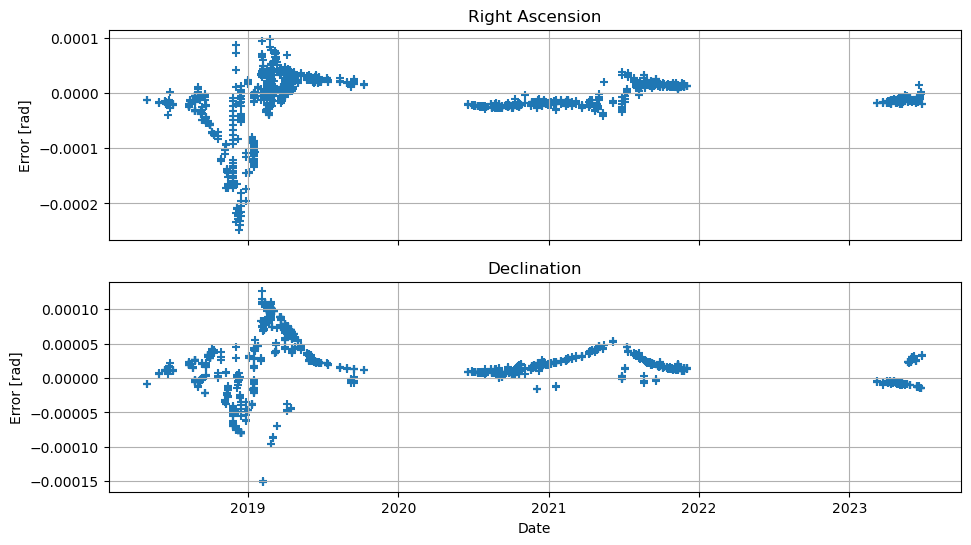

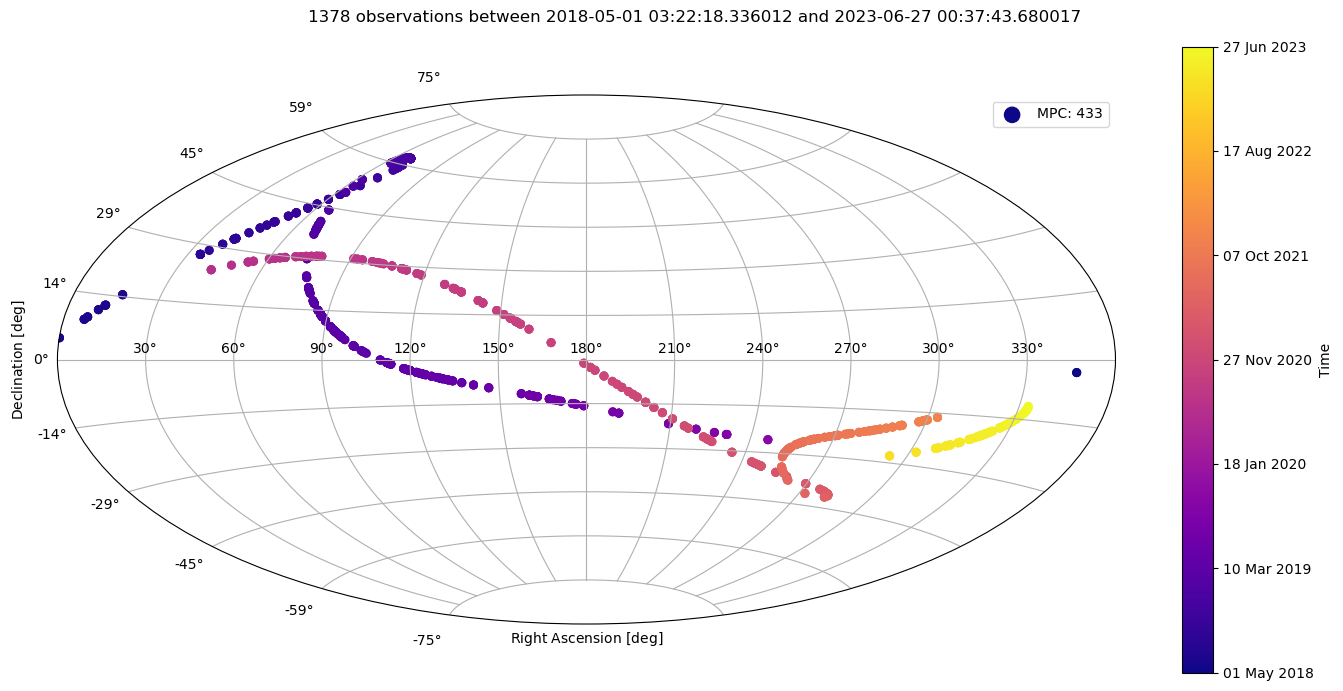

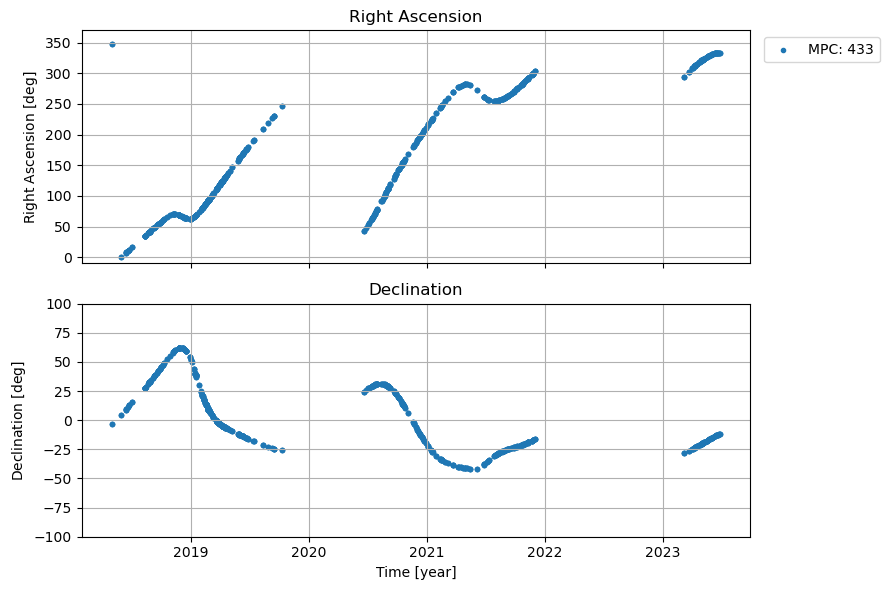

In [49]:
# create plot
fig, (ax_ra, ax_dec) = plt.subplots(2, 1, figsize=(11, 6), sharex=True)

#print(f'RA residuals:\n {jpl_RA - batch_RA}')
#print(f'DEC residuals:\n + {jpl_DEC-batch_DEC}')

ax_ra.scatter(batch_times_utc, (jpl_RA - batch_RA), marker="+")
ax_dec.scatter(batch_times_utc, (jpl_DEC - batch_DEC), marker="+")

ax_ra.set_ylabel("Error [rad]")
ax_dec.set_ylabel("Error [rad]")
ax_dec.set_xlabel("Date")

ax_ra.grid()
ax_dec.grid()

ax_ra.set_title("Right Ascension")
ax_dec.set_title("Declination")

plt.show()

### Plotting observations
"""
The `.plot_observations_sky()` method can be used to view a projection of the observations. Similarly, `.plot_observations_temporal()` shows the declination and right ascension of a batch's bodies over time.
"""

#print(f'batch_RA in radians from table.query: \n\n{batch_RA}') 
#print(f'batch_RA in degrees: \n\n{np.degrees(batch_RA)}') 
#print(f'batch_DEC in radians from table.query: \n\n{batch_DEC}') 
#print(f'batch_DEC in degrees: \n\n{np.degrees(batch_DEC)}') 

# Try some of the other projections: 'hammer', 'mollweide' and 'lambert'
fig = batch1.plot_observations_sky(projection = 'aitoff')
plt.show()

fig = batch1.plot_observations_temporal()
plt.show()

In [42]:
from tudatpy.util import result2array

# Retrieve the first and final observation epochs and add the buffer
epoch_start_nobuffer = batch1.epoch_start
epoch_end_nobuffer = batch1.epoch_end

print(f'Epoch Start (no buffer): {epoch_start_nobuffer}')
print(f'Epoch End (no buffer): {epoch_end_nobuffer}')

time_buffer = 1 * 31 * 86400

#number of iterations for our estimation
number_of_pod_iterations = 6

# timestep of 300s for our estimation
timestep_global = 20*3600

epoch_start_buffer = epoch_start_nobuffer - time_buffer 
epoch_end_buffer = epoch_end_nobuffer + time_buffer 

print(f'Epoch Start (with buffer): {epoch_start_buffer}')
print(f'Epoch End (with buffer): {epoch_end_buffer}')

Epoch Start (no buffer): 578417007.5214744
Epoch End (no buffer): 741098332.8642726
Epoch Start (with buffer): 575738607.5214744
Epoch End (with buffer): 743776732.8642726


In [43]:
# Define accelerations
accelerations = {
    "Sun": [
        propagation_setup.acceleration.point_mass_gravity(),
        propagation_setup.acceleration.relativistic_correction(use_schwarzschild=True),
    ],
    "Mercury": [propagation_setup.acceleration.point_mass_gravity()],
    "Venus": [propagation_setup.acceleration.point_mass_gravity()],
    "Earth": [propagation_setup.acceleration.point_mass_gravity()],
    "Moon": [propagation_setup.acceleration.point_mass_gravity()],
    "Mars": [propagation_setup.acceleration.point_mass_gravity()],
    "Jupiter": [propagation_setup.acceleration.point_mass_gravity()],
    "Saturn": [propagation_setup.acceleration.point_mass_gravity()],
    "Uranus": [propagation_setup.acceleration.point_mass_gravity()],
    "Neptune": [propagation_setup.acceleration.point_mass_gravity()],
}

# Set up the accelerations settings for each body, in this case only Eros
acceleration_settings = {}
for body in batch1.MPC_objects:
    acceleration_settings[str(body)] = accelerations

acceleration_settings
# create the acceleration models.
acceleration_models = propagation_setup.create_acceleration_models(
    bodies, acceleration_settings, bodies_to_propagate, central_bodies
)


#benchmark state for later comparison retrieved from SPICE
initial_states = spice.get_body_cartesian_state_at_epoch(
    'Eros',
    global_frame_origin,
    global_frame_orientation,
    "NONE",
    epoch_start_buffer,
)

print(initial_states)

[ 1.64762555e+11 -1.92563502e+11 -7.97760435e+10  1.48565581e+04
  9.90463935e+03  8.31019543e+03]


In [44]:
target_spkid = '433'

#benchmark state for later comparison retrieved from SPICE
#initial_states = spice.get_body_cartesian_state_at_epoch(
#    'Eros',
#    global_frame_origin,
#    global_frame_orientation,
#    "NONE",
#    epoch_start_buffer,
#)

print(initial_states)
# benchmark state for later comparison retrieved from SPICE
#initial_states = spice.get_body_cartesian_state_at_epoch(
#    'Eros',
#    global_frame_origin,
#    global_frame_orientation,
#    "NONE",
#    epoch_start_buffer,
#)

spice_state_list = []
epochs_spice = np.arange(epoch_start_buffer, epoch_end_buffer, 100)

for epoch in epochs_spice:
    spice_state = spice.get_body_cartesian_state_at_epoch(
        'Eros',
        global_frame_origin,
        global_frame_orientation,
        "NONE",
        epoch,
    )
    spice_state_list.append(list(spice_state))

# Add random offset for initial guess
np.random.seed = 1

initial_position_offset = 1e6*1000
initial_velocity_offset = 100

initial_guess = initial_states.copy()
initial_guess[0:3] += (2 * np.random.rand(3) - 1) * initial_position_offset
initial_guess[3:6] += (2 * np.random.rand(3) - 1) * initial_velocity_offset

print("Error between the real initial state and our initial guess:")
print(initial_guess - initial_states)

[ 1.64762555e+11 -1.92563502e+11 -7.97760435e+10  1.48565581e+04
  9.90463935e+03  8.31019543e+03]
Error between the real initial state and our initial guess:
[-1.26056724e+08 -2.79939548e+08  5.58996501e+08  2.13010773e+01
  3.95115745e+01 -4.74292841e+01]


In [45]:
# Create numerical integrator settings
integrator_settings = propagation_setup.integrator.runge_kutta_variable_step_size(
    epoch_start_buffer,
    timestep_global,
    propagation_setup.integrator.rkf_78,
    timestep_global,
    timestep_global,
    1.0,
    1.0,
)

x_spice = [state[0] for state in spice_state_list]
y_spice = [state[1] for state in spice_state_list]
z_spice = [state[2] for state in spice_state_list]

# Terminate at the time of oldest observation
termination_condition = propagation_setup.propagator.time_termination(epoch_end_buffer)

# Create propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies=central_bodies,
    acceleration_models=acceleration_models,
    bodies_to_integrate=bodies_to_propagate,
    initial_states=initial_guess,
    initial_time=epoch_start_buffer,
    integrator_settings=integrator_settings,
    termination_settings=termination_condition,
)

/opt/anaconda3/envs/tudat-bundle/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


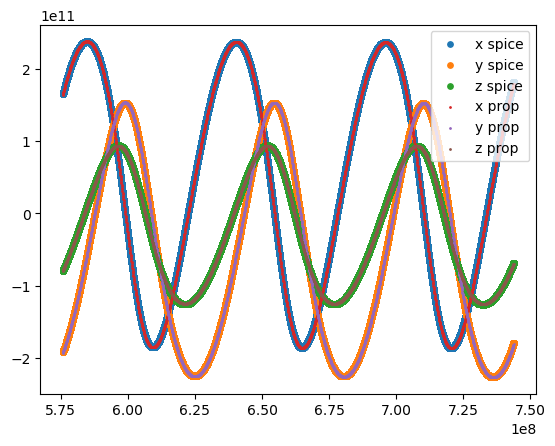

Error between the real spice final state and our final state:
[-2.56131609e+09 -2.36095471e+09 -1.15227984e+09  2.60175944e+02
 -1.93128779e+02 -1.42092025e+02]


In [46]:
# Create simulation object and propagate the dynamics
dynamics_simulator = numerical_simulation.create_dynamics_simulator(
    bodies, propagator_settings
)

# Extract the resulting state history and convert it to an ndarray
states = dynamics_simulator.propagation_results.state_history
states_array = result2array(states)

time_prop = [state[0] for state in states_array]
x_prop = [state[1] for state in states_array]
y_prop = [state[2] for state in states_array]
z_prop = [state[3] for state in states_array]


plt.scatter(epochs_spice, x_spice, s = 15, label = 'x spice')
plt.scatter(epochs_spice, y_spice, s = 15, label = 'y spice')
plt.scatter(epochs_spice, z_spice, s = 15, label = 'z spice')
plt.scatter(time_prop, x_prop, s = 1, label = 'x prop')
plt.scatter(time_prop, y_prop, s = 1, label = 'y prop')
plt.scatter(time_prop, z_prop, s = 1, label = 'z prop')


plt.legend()
plt.show()

states_array[:]
print("Error between the real spice final state and our final state:")
print(states_array[-1][1:] - spice_state_list[-1][:])

In [47]:
# Setup parameters settings to propagate the state transition matrix
parameter_settings = estimation_setup.parameter.initial_states(
    propagator_settings, bodies
)

# Create the parameters that will be estimated
parameters_to_estimate = estimation_setup.create_parameter_set(
    parameter_settings, bodies, propagator_settings
)

In [48]:
# Set up the estimator
estimator = numerical_simulation.Estimator(
    bodies=bodies,
    estimated_parameters=parameters_to_estimate,
    observation_settings=observation_settings_list,
    propagator_settings=propagator_settings,
    integrate_on_creation=True,
)

# provide the observation collection as input, and limit number of iterations for estimation.
pod_input = estimation.EstimationInput(
    observations_and_times=observation_collection,
    convergence_checker=estimation.estimation_convergence_checker(
        maximum_iterations=number_of_pod_iterations,
    ),
)

# Set methodological options
pod_input.define_estimation_settings(reintegrate_variational_equations=True)
# Perform the estimation

pod_output = estimator.perform_estimation(pod_input)

Calculating residuals and partials 2752
Current residual: 0.010315
Parameter update 1.33898e+08  2.77478e+08 -5.56272e+08     -22.2009     -39.0638      47.8521
Calculating residuals and partials 2752
Current residual: 0.000146461
Parameter update-7.89876e+06  2.45188e+06 -2.76635e+06     0.903467    -0.451609    -0.421395
Calculating residuals and partials 2752
Current residual: 1.82337e-06
Parameter update    -2821.85      -620.71      -1583.4   0.00017861 -0.000201438 -1.54552e-05
Calculating residuals and partials 2752
Current residual: 1.82324e-06
Parameter update -0.00880832  -0.00177875  -0.00251791  6.41639e-10 -4.56294e-10 -9.72681e-11
Calculating residuals and partials 2752
Current residual: 1.82324e-06
Parameter update  0.00685883 -0.000488748   0.00156861 -6.08454e-10  3.99787e-10  1.00821e-10
Calculating residuals and partials 2752
Current residual: 1.82324e-06
Maximum number of iterations reached
Parameter update  -0.0115942  -0.00154242  -0.00296219  8.89969e-10 -6.05927